In [1]:
import gzip
import pickle 
import mplhep as hep
hep.style.use("CMS")
import matplotlib
matplotlib.rc('font', size=15)
import numpy as np
import torch 
import dgl
import pandas as pd
import numpy as np
import plotly.express as px
import sys
sys.path.append("/afs/cern.ch/work/m/mgarciam/private/mlpf/")
from sklearn.cluster import DBSCAN
from torch_scatter import scatter_max, scatter_add, scatter_mean
from src.layers.inference_oc import get_clustering, obtain_intersection_values
from scipy.optimize import linear_sum_assignment
import numpy as np
import matplotlib.pyplot as plt

/afs/cern.ch/work/m/mgarciam/private/miniconda/miniconda3/envs/graphgps0/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from src.utils.inference.pandas_helpers import open_mlpf_dataframe
list_all_df_hdb = []
path_hgcal = "/eos/user/m/mgarciam/datasets_mlpf/models_trained_CLD/eval_gun_dr05_271124/showers_df_evaluation/0_0_None_hdbscan.pt"
sd_hgb, matched_hgb = open_mlpf_dataframe(path_hgcal, False)
sd_hgb = sd_hgb[sd_hgb.reco_showers_E>0]
path_hgcal = "/eos/user/m/mgarciam/datasets_mlpf/models_trained_CLD/eval_gun_dr05_271124/showers_df_evaluation/0_0_None_pandora.pt"
sd_pandora, matched_hgbq1 = open_mlpf_dataframe(path_hgcal, False)
sd_pandora = sd_pandora[sd_pandora.reco_showers_E>0]

In [15]:
batch_id = 6
sd_hgb[(sd_hgb.number_batch==batch_id)*(sd_hgb.is_track_correct==0)*(sd_hgb.is_track_in_cluster==1)]
sd_hgb[(sd_hgb.number_batch==batch_id)]

,true_showers_E,reco_showers_E,pred_showers_E,e_pred_and_truth,pid,calibration_factor,calibrated_E,step,number_batch,is_track_in_cluster,...,distance_to_cluster_MC,vertex,ECAL_hits,HCAL_hits,pred_pos_matched,pred_pid_matched,pred_ref_pt_matched,matched_extra_features,true_pos,pid_4_class_true
0,11.243949,11.259464,11.229308,11.229308,22.0,11.780870,11.780870,0.0,6.0,0.0,...,0.000000,"[0.0, 0.0, 0.0]",347.0,1.0,"[0.7463075518608093, -0.22314131259918213, -0....",3.0,"[2174.981201171875, -650.3058471679688, -1827....","[348.0, 0.9780805110931396]","[8.392719268798828, -2.506556510925293, -7.050...",3.0
1,0.941240,0.739408,0.759680,0.709626,130.0,1.239391,1.239391,0.0,6.0,0.0,...,0.000000,"[0.0, 0.0, 0.0]",23.0,0.0,"[0.9776802659034729, -0.13699223101139069, -0....",3.0,"[2214.6474609375, -310.315673828125, -360.8330...","[23.0, 0.758774995803833]","[0.7819837927818298, -0.09265126287937164, -0....",2.0
2,41.175358,38.375771,31.257463,31.257458,2112.0,42.639050,42.639050,0.0,6.0,0.0,...,0.000000,"[0.0, 0.0, 0.0]",608.0,237.0,"[0.9834303259849548, 0.11815786361694336, -0.1...",2.0,"[2541.85400390625, 305.4004211425781, -355.368...","[845.0, 0.7305724024772644]","[40.55238723754883, 4.1759443283081055, -5.709...",2.0
3,4.996181,4.948079,4.948079,4.948079,22.0,5.449508,5.449508,0.0,6.0,0.0,...,0.000000,"[0.0, 0.0, 0.0]",193.0,0.0,"[0.9371985197067261, 0.0891566127538681, -0.33...",3.0,"[2207.56494140625, 210.0078125, -794.294250488...","[193.0, 0.922469437122345]","[4.683120250701904, 0.44881486892700195, -1.68...",3.0
4,8.189672,7.988235,6.308640,6.248728,11.0,6.184355,6.184355,0.0,6.0,0.0,...,0.097659,"[0.0, 0.0, 0.0]",189.0,0.0,"[0.9976065754890442, -0.0690293163061142, -0.0...",3.0,"[2232.516357421875, -154.4788055419922, -9.005...","[189.0, 0.5447254776954651]","[8.126444816589355, -1.014970064163208, -0.038...",0.0
5,1.451659,1.462788,1.475738,1.462788,11.0,1.545080,1.545080,0.0,6.0,0.0,...,0.420012,"[0.0, 0.0, 0.0]",67.0,0.0,"[0.8181938529014587, 0.5681670904159546, -0.08...",3.0,"[1797.6195068359375, 1248.296142578125, -193.3...","[67.0, 0.9738001823425293]","[1.414283275604248, 0.30250516533851624, -0.12...",0.0
6,13.378465,16.628372,16.112482,16.112478,130.0,18.804729,18.804729,0.0,6.0,0.0,...,0.000000,"[0.0, 0.0, 0.0]",381.0,37.0,"[0.8621667623519897, -0.5050159692764282, -0.0...",2.0,"[1976.2862548828125, -1157.61376953125, -92.47...","[418.0, 0.9440118074417114]","[11.57700252532959, -6.664433479309082, -0.542...",2.0
7,18.131939,20.962606,21.435825,20.873877,130.0,24.220900,24.220900,0.0,6.0,0.0,...,0.000000,"[0.0, 0.0, 0.0]",0.0,205.0,"[0.9734950661659241, -0.022969236597418785, -0...",2.0,"[3074.44970703125, -72.54043579101562, -718.64...","[206.0, 0.8904823064804077]","[17.622032165527344, -0.41072624921798706, -4....",2.0
8,6.211805,5.383601,5.383602,5.383601,130.0,6.543865,6.543865,0.0,6.0,0.0,...,0.000000,"[0.0, 0.0, 0.0]",205.0,8.0,"[0.8478429913520813, -0.011085405014455318, -0...",3.0,"[2300.373046875, -30.07699203491211, -1438.356...","[213.0, 0.9523426294326782]","[5.243138313293457, -0.06998781114816666, -3.2...",2.0
9,1.068120,1.206382,1.206382,1.206382,-211.0,1.055989,1.055989,0.0,6.0,1.0,...,0.133656,"[0.0, 0.0, 0.0]",48.0,7.0,"[0.9426799416542053, -0.2770684063434601, 0.18...",1.0,"[0.04070842266082764, 0.0653960108757019, 0.02...","[56.0, 0.9509370923042297]","[0.9984117746353149, -0.29264408349990845, 0.1...",1.0


In [17]:
sd_hgb[(sd_hgb.number_batch==batch_id)].is_track_in_MC[5], sd_hgb[(sd_hgb.number_batch==batch_id)].is_track_in_cluster[5]

(1, 0.0)

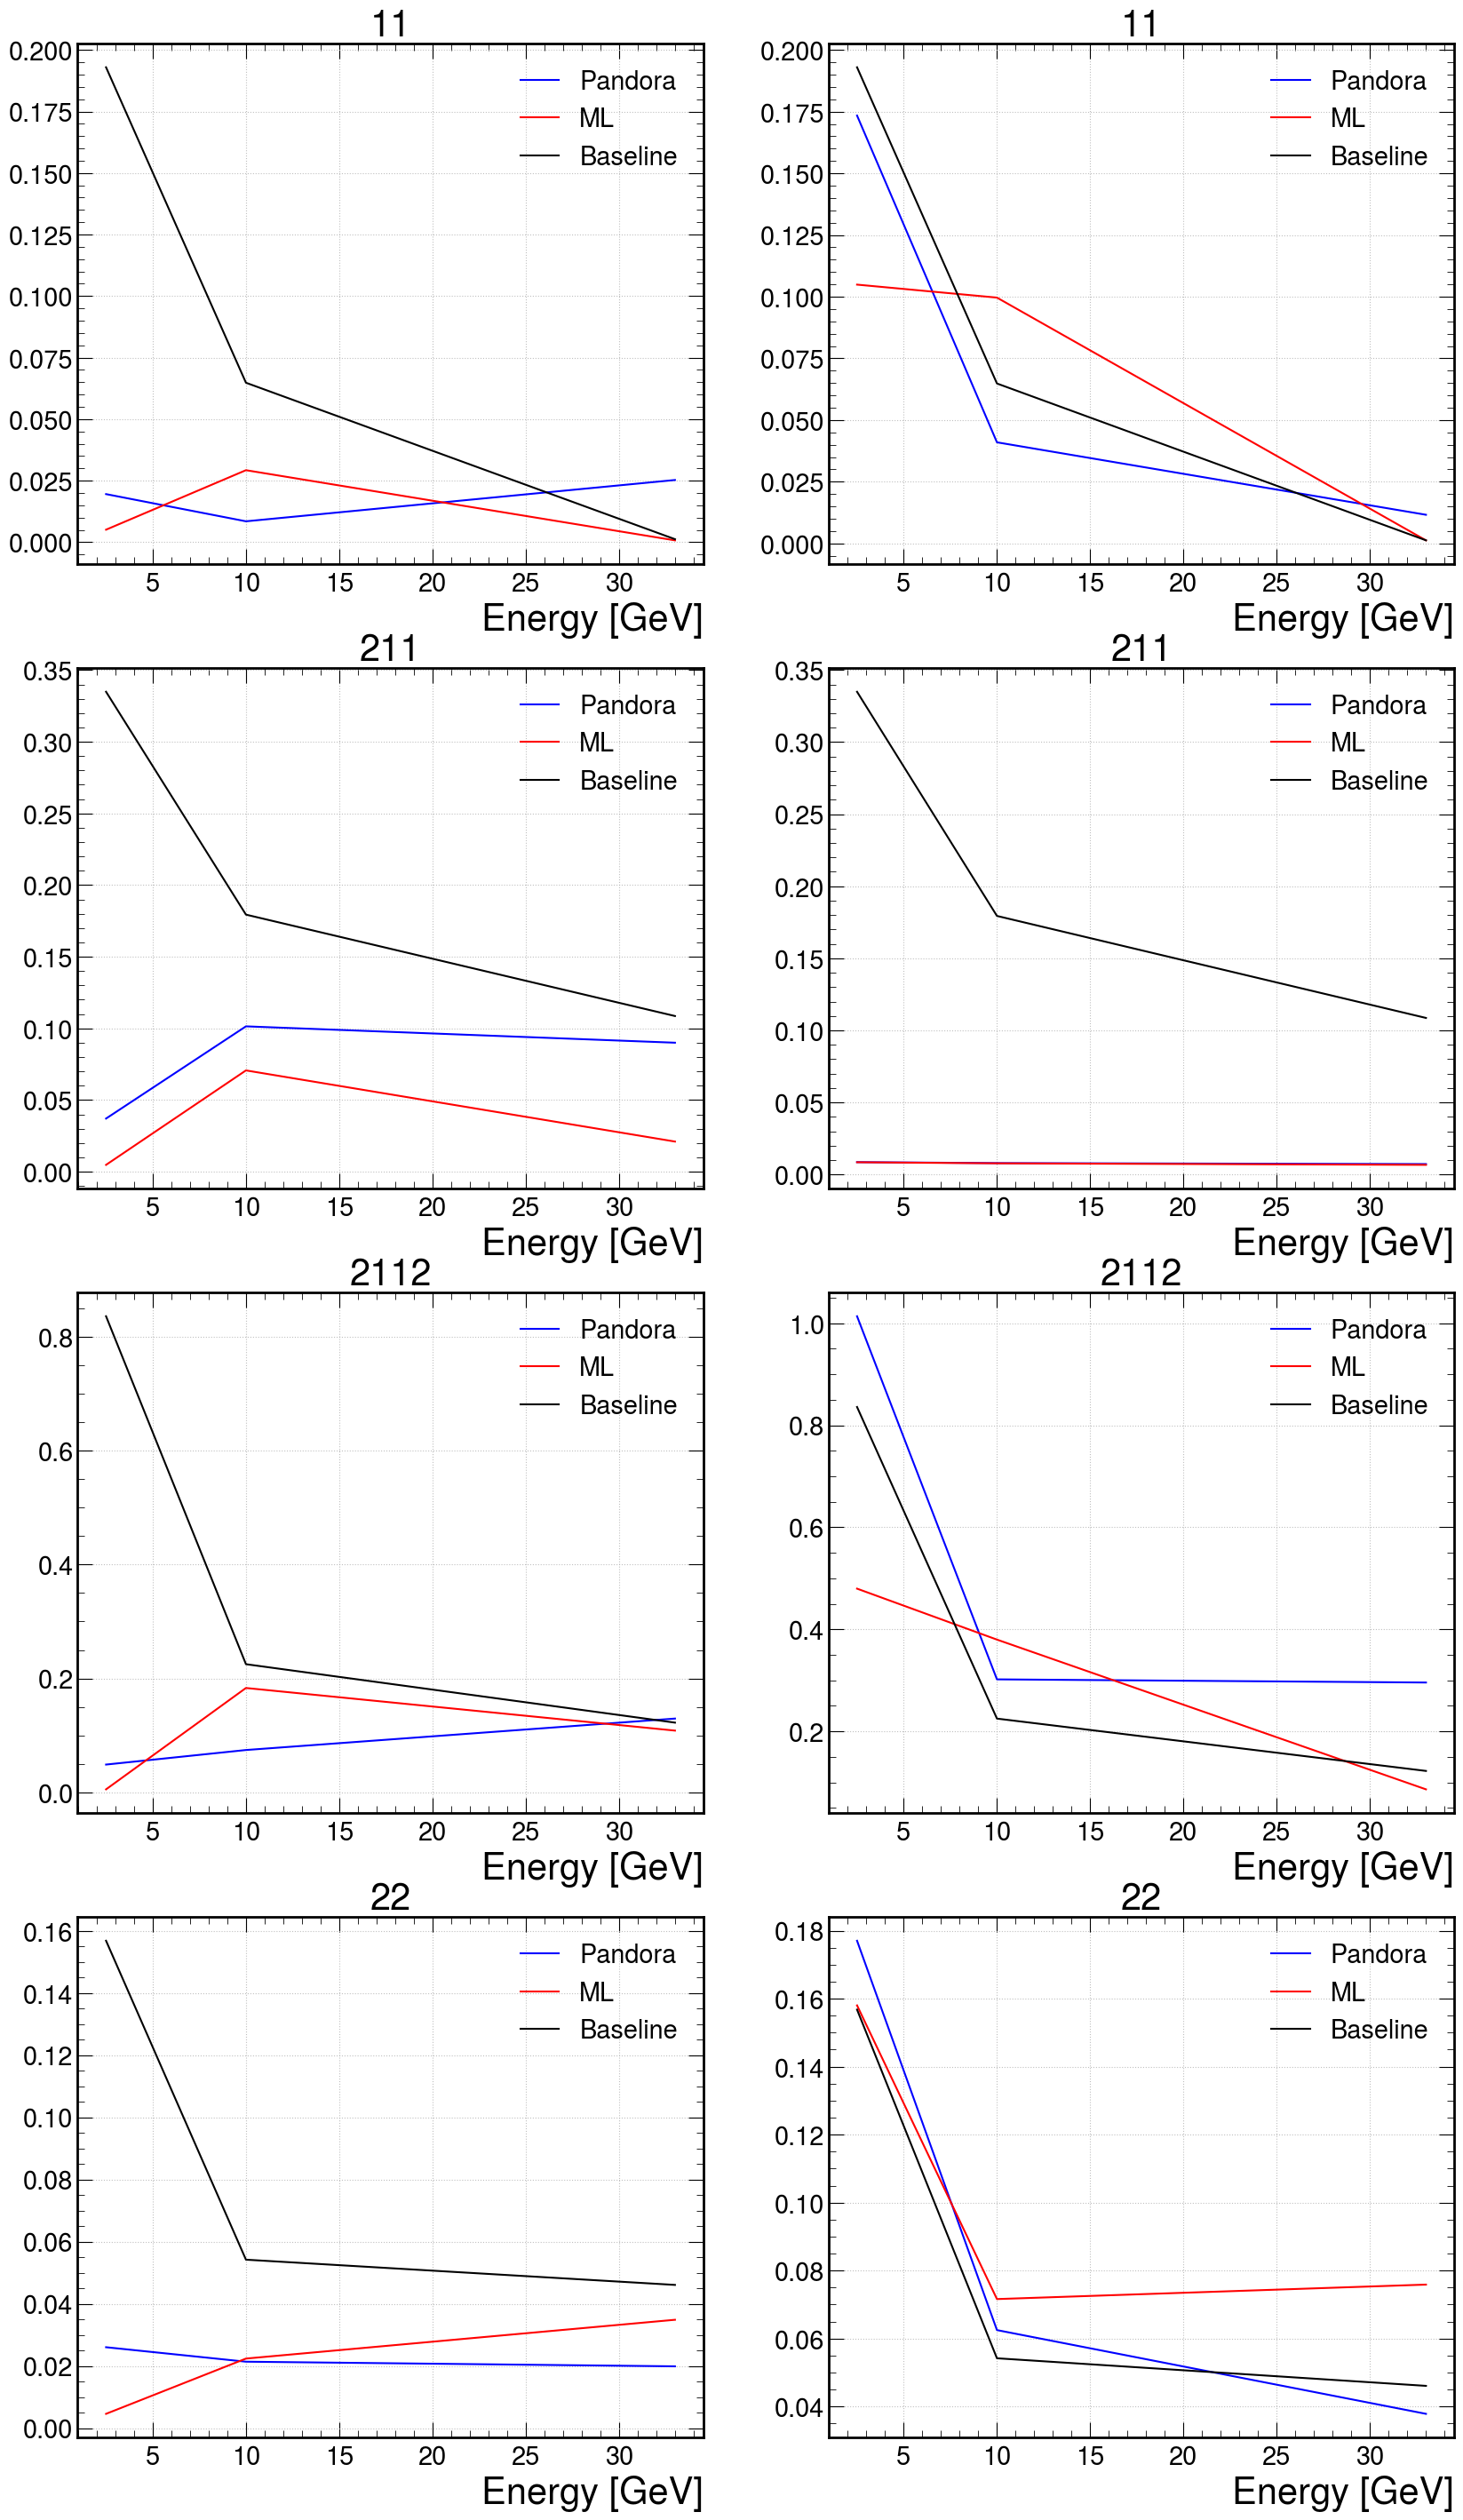

In [44]:
d_11= np.load("/eos/user/m/mgarciam/datasets_mlpf/models_trained_CLD/041124_eval_061024_cont2/plots_range_0_5000/11.npy",allow_pickle=True)
d_22= np.load("/eos/user/m/mgarciam/datasets_mlpf/models_trained_CLD/041124_eval_061024_cont2/plots_range_0_5000/22.npy",allow_pickle=True)
d_211= np.load("/eos/user/m/mgarciam/datasets_mlpf/models_trained_CLD/041124_eval_061024_cont2/plots_range_0_5000/211.npy",allow_pickle=True)
d_2112= np.load("/eos/user/m/mgarciam/datasets_mlpf/models_trained_CLD/041124_eval_061024_cont2/plots_range_0_5000/2112.npy",allow_pickle=True)
dics = [d_11,d_211, d_2112, d_22 ]
pids = ["11", "211", "2112", "22"]
fig_distr, ax_distr = plt.subplots(4,2,figsize=(20, 35))
for i, dic in enumerate(dics):
    dic = dic.item()
    ax_distr[i,0].plot(dic["energy_resolutions_p"], dic["variance_om_p_reco"], c="blue", label="Pandora")
    ax_distr[i,0].plot(dic["energy_resolutions"], dic["variance_om_reco"], c="red", label="ML")
    ax_distr[i,0].plot(dic["energy_resolutions"], dic["variance_om_baseline"], c="k", label="Baseline")
    ax_distr[i,0].set_xlabel("Energy [GeV]", fontsize=30)
    ax_distr[i,0].grid()
    ax_distr[i,0].legend()
    ax_distr[i,0].set_title(pids[i])

    ax_distr[i,1].plot(dic["energy_resolutions_p"], dic["variance_om_p"], c="blue", label="Pandora")
    ax_distr[i,1].plot(dic["energy_resolutions"], dic["variance_om"], c="red", label="ML")
    ax_distr[i,1].plot(dic["energy_resolutions"], dic["variance_om_baseline"], c="k", label="Baseline")
    ax_distr[i,1].set_xlabel("Energy [GeV]", fontsize=30)
    ax_distr[i,1].grid()
    ax_distr[i,1].legend()
    ax_distr[i,1].set_title(pids[i])
    # ax_distr[i].set_yscale("log")

In [25]:
d_11.item()['mean_p']

[0.98829204227935, 0.9964530186170598, 1.0705418778117213]

<Axes: ylabel='Probability'>

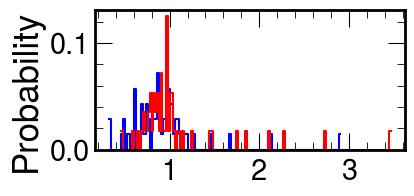

In [15]:
E_range = 15
E_range1 = 5
pid = 130
import seaborn as sns
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(2, 1, 1)
sns.histplot(sd_hgb.pred_showers_E[(sd_hgb.pid == pid)*(sd_hgb.reco_showers_E<E_range)*(sd_hgb.reco_showers_E>E_range1)]/sd_hgb.reco_showers_E[(sd_hgb.pid == pid)*(sd_hgb.reco_showers_E<E_range)*(sd_hgb.reco_showers_E>E_range1)], stat="probability",binwidth=0.02, color="blue",  element="step",fill=False)
sns.histplot(sd_pandora.pred_showers_E[(sd_pandora.pid == pid)*(sd_pandora.reco_showers_E<E_range)*(sd_pandora.reco_showers_E>E_range1)]/sd_pandora.reco_showers_E[(sd_pandora.pid == pid)*(sd_pandora.reco_showers_E<E_range)*(sd_pandora.reco_showers_E>E_range1)], stat="probability",binwidth=0.02, color="red",  element="step",fill=False)


In [12]:
E_cor = sd_hgb.pred_showers_E[(sd_hgb.pid == 22)*(sd_hgb.reco_showers_E<E_range)*(sd_hgb.reco_showers_E>E_range1)]/sd_hgb.reco_showers_E[(sd_hgb.pid == 22)*(sd_hgb.reco_showers_E<E_range)*(sd_hgb.reco_showers_E>E_range1)]
np.mean(E_cor), np.var(E_cor)

(1.0189116, 0.041498035192489624)

In [23]:
number_batch = 0
pred_E =np.array(sd_hgb[(sd_hgb.number_batch==number_batch)*(sd_hgb.true_showers_E<30)*(sd_hgb.e_pred_and_truth>0)].calibrated_E.values.tolist())
print(len(pred_E))
true_E =np.array(sd_hgb[(sd_hgb.number_batch==number_batch)*(sd_hgb.true_showers_E<30)*(sd_hgb.e_pred_and_truth>0)].true_showers_E.values.tolist())

pandora_E =np.array(sd_pandora[(sd_pandora.number_batch==number_batch)*(sd_pandora.true_showers_E<30)*(sd_pandora.e_pred_and_truth>0)].pandora_calibrated_pfo.values.tolist())
np.sum(pred_E[~np.isnan(pred_E)]), np.sum(true_E[~np.isnan(true_E)]), np.sum(pandora_E[~np.isnan(pandora_E)])

26


(79.5766966342926, 94.15142951905727, 90.16831351816654)

In [110]:
# E_pred = (sd_pandora[(sd_pandora.number_batch==number_batch)*((sd_pandora.pred_showers_E>0))].pandora_calibrated_pfo.values)
# E_pred_ml = (sd_hgb[(sd_hgb.number_batch==number_batch)*((sd_hgb.pred_showers_E>0))].calibrated_E.values)
# E_true = (sd_pandora[(sd_pandora.number_batch==number_batch)*((sd_pandora.pred_showers_E>0))].true_showers_E.values)
# E_true_ml = (sd_hgb[(sd_hgb.number_batch==number_batch)*((sd_hgb.pred_showers_E>0))].true_showers_E.values)
# print(E_pred/E_true)
# print(E_pred_ml/E_true_ml)
# import seaborn as sns
# fig = plt.figure(figsize=(4,4))
# sns.histplot(E_pred/E_true, stat="density", binwidth=0.02,color="r")
# sns.histplot(E_pred_ml/E_true_ml, stat="density", binwidth=0.02, color="g")


In [6]:
pred_vect =np.array(sd_hgb[(sd_hgb.number_batch==number_batch)*(sd_hgb.true_showers_E<30)*((sd_hgb.e_pred_and_truth>0))].pred_pos_matched.values.tolist())
nan_mask = np.isnan(np.sum(pred_vect,axis=1))
pred_vect[nan_mask] = 0
pred_vect /= np.linalg.norm(pred_vect, axis=1).reshape(-1, 1)
pred_vect[np.isnan(pred_vect)] = 0
p_squared = (pred_E ** 2)
p_squared[p_squared < 0] = 0 # they are always like of order -1e-8
pred_vect = np.sqrt(p_squared).reshape(-1, 1) * np.array(pred_vect)




pred_vect_pandora =np.array(sd_pandora[(sd_pandora.number_batch==number_batch)*(sd_pandora.true_showers_E<30)*((sd_pandora.e_pred_and_truth>0))].pandora_calibrated_pos.values.tolist())
nan_mask = np.isnan(np.sum(pred_vect_pandora,axis=1))
pred_vect_pandora[nan_mask] = 0
pred_vect_pandora /= np.linalg.norm(pred_vect_pandora, axis=1).reshape(-1, 1)
pred_vect_pandora[np.isnan(pred_vect_pandora)] = 0
p_squared = (pandora_E ** 2)
p_squared[p_squared < 0] = 0 # they are always like of order -1e-8
pred_vect_pandora = np.sqrt(p_squared).reshape(-1, 1) * np.array(pred_vect_pandora)



true_vect = np.array(sd_hgb[(sd_hgb.number_batch==number_batch)*(sd_hgb.true_showers_E<30)*((sd_hgb.e_pred_and_truth>0))].true_pos.values.tolist())
true_vect = true_vect 


In [115]:
true_v = np.nansum(true_vect, axis=0)
pred_v = np.nansum(pred_vect, axis=0)
pandora_v = np.nansum(pred_vect_pandora, axis=0)
pandora_v = pandora_v

torch.norm(torch.Tensor(true_v).view(1,-1), dim=1), torch.norm(torch.Tensor(pred_v).view(1,-1), dim=1), torch.norm(torch.Tensor(pandora_v).view(1,-1), dim=1)

(tensor([8.7547]), tensor([8.6643]), tensor([9.4493]))

In [116]:
true_E_jet = torch.Tensor([np.sum(true_E[~np.isnan(true_E)])])
true_jet_p = torch.norm(torch.Tensor(true_v).view(1,-1), dim=1)
mass_t = torch.sqrt(torch.abs(true_E_jet ** 2) - true_jet_p ** 2)
print("mass_t", mass_t, true_E_jet, true_jet_p)

true_E_jet = torch.Tensor([np.sum(pred_E[~np.isnan(pred_E)])])
true_jet_p = torch.norm(torch.Tensor(pred_v).view(1,-1), dim=1)
mass_t = torch.sqrt(torch.abs(true_E_jet ** 2) - true_jet_p ** 2)
print("mass_pred", mass_t, true_E_jet, true_jet_p)


true_E_jet = torch.Tensor([np.sum(pandora_E[~np.isnan(pandora_E)])])
true_jet_p = torch.norm(torch.Tensor(pandora_v).view(1,-1), dim=1)
mass_t = torch.sqrt(torch.abs(true_E_jet ** 2) - true_jet_p ** 2)
print("mass_pandora", mass_t, true_E_jet, true_jet_p)

mass_t tensor([59.4473]) tensor([60.0885]) tensor([8.7547])
mass_pred tensor([58.4737]) tensor([59.1121]) tensor([8.6643])
mass_pandora tensor([56.6480]) tensor([57.4307]) tensor([9.4493])


In [4]:
sd_hgb.calibrated_E[(~np.isnan(sd_hgb.calibrated_E)) & (sd_hgb.pid==22)] = sd_hgb.pred_showers_E[(~np.isnan(sd_hgb.calibrated_E)) & ((sd_hgb.pid==22))]
sd_hgb_filtered = sd_hgb
x = sd_hgb_filtered.pred_ref_pt_matched[sd_hgb_filtered.is_track_in_cluster==1].values
x = np.stack(x)
x = np.linalg.norm(x, axis=1)
idx_pick_reco = np.where(x > 0.25)[0] 
sd_hgb_filtered[sd_hgb_filtered.is_track_in_cluster==1].calibrated_E.iloc[idx_pick_reco] = sd_hgb_filtered[sd_hgb_filtered.is_track_in_cluster==1].pred_showers_E.iloc[idx_pick_reco]
df = sd_hgb_filtered
pandora = False
perfect_pid=False
mass_zero=True
ML_pid=False
from torch_scatter import scatter_sum, scatter_mean
from src.utils.inference.inference_metrics import get_sigma_gaussian
from src.utils.inference.event_metrics import calculate_event_mass_resolution
particle_masses = {0: 0, 22: 0, 11: 0.00511, 211: 0.13957, 130: 0.493677, 2212: 0.938272, 2112: 0.939565}
particle_masses_4_class = {0: 0.00511, 1: 0.13957, 2: 0.939565, 3: 0.0} # electron, CH, NH, photon
def safeint(x, default_val=0):
    if np.isnan(x):
        return default_val
    return int(x)

mean_mass_p, var_mass_p, distr_mass_p, mass_true_p, _, _, E_over_true_pandora = calculate_event_mass_resolution(sd_pandora, True, perfect_pid=perfect_pid, mass_zero=mass_zero, ML_pid=ML_pid)
mean_mass, var_mass, distr_mass, mass_true, _, _, E_over_true = calculate_event_mass_resolution(sd_hgb_filtered, False, perfect_pid=perfect_pid, mass_zero=mass_zero, ML_pid=ML_pid)
   


/tmp/mgarciam/ipykernel_772457/1490366686.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sd_hgb.calibrated_E[(~np.isnan(sd_hgb.calibrated_E)) & (sd_hgb.pid==22)] = sd_hgb.pred_showers_E[(~np.isnan(sd_hgb.calibrated_E)) & ((sd_hgb.pid==22))]
/tmp/mgarciam/ipykernel_772457/1490366686.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sd_hgb.calibrated_E[(~np.isnan(sd_hgb.calibrated_E)) & (sd_hgb.pid==22)] = sd_hgb.pred_showers_E[(~np.isnan(sd_hgb.calibrated_E)) & ((sd_hgb.pid==22))]
/tmp/mgarciam/ipykernel_772457/1490366686.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

FILDETED 55606
true_E_jet tensor(108.4395)
pred_E_jet tensor(117.2127)
true_jet_p tensor(18.2562, dtype=torch.float64)
pred_jet_p tensor(23.8851, dtype=torch.float64)
EVALUATING MASS True 0.9978427208716505 0.042089241307109386
FILDETED 58906
sum nan mas 10281
true_E_jet tensor(108.4395)
pred_E_jet tensor(100.5228)
true_jet_p tensor(18.2562, dtype=torch.float64)
pred_jet_p tensor(15.0057, dtype=torch.float64)
EVALUATING MASS False 1.005769104807969 0.04227274524363233


In [15]:
print(mean_mass_p, var_mass_p)
print(mean_mass, var_mass)

0.9978427208716505 0.042089241307109386
1.005769104807969 0.04227274524363233


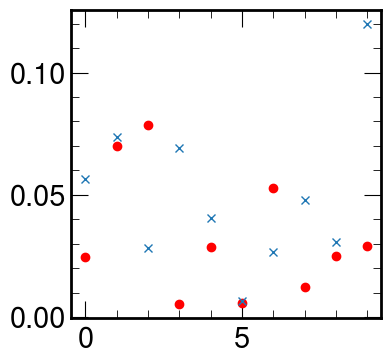

In [98]:
plt.figure(figsize=(4,4))
plt.plot(np.abs(1-distr_mass[0:10]), 'or')
plt.plot(np.abs(1-distr_mass_p[0:10]), 'x')


In [ ]:
number_batch = 2
pred_E =np.array(sd_hgb[(sd_hgb.number_batch==number_batch)*((sd_hgb.reco_showers_E>0)+(sd_hgb.pred_showers_E>0))].calibrated_E.values.tolist())
print(len(pred_E))
true_E =np.array(sd_hgb[(sd_hgb.number_batch==number_batch)*((sd_hgb.reco_showers_E>0)+(sd_hgb.pred_showers_E>0))].true_showers_E.values.tolist())

pandora_E =np.array(sd_pandora[(sd_pandora.number_batch==number_batch)*((sd_pandora.reco_showers_E>0)+(sd_pandora.pred_showers_E>0))].pandora_calibrated_pfo.values.tolist())
np.sum(pred_E[~np.isnan(pred_E)]), np.sum(true_E[~np.isnan(true_E)]), np.sum(pandora_E[~np.isnan(pandora_E)])

<Axes: ylabel='Density'>

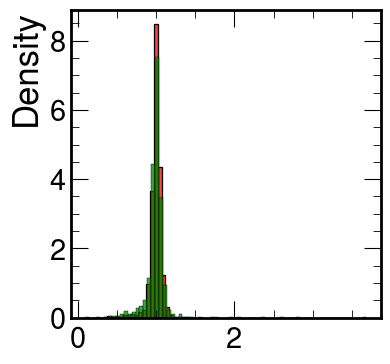

In [11]:
import seaborn as sns
fig = plt.figure(figsize=(4,4))
sns.histplot(distr_mass_p, stat="density", binwidth=0.05,color="r")
sns.histplot(distr_mass, stat="density", binwidth=0.05, color="g")


In [86]:
mean_mass, var_mass

(0.9833691480594117, 0.05221169997540143)

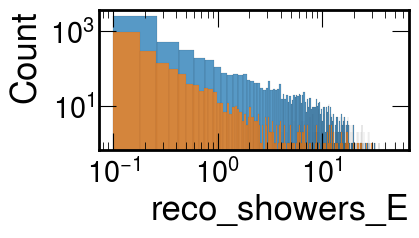

In [44]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(2, 1, 1)
sns.histplot(sd_pandora[np.isnan(sd_pandora.pred_showers_E)*(sd_pandora.reco_showers_E>0.1)].reco_showers_E)
sns.histplot(sd_hgb[np.isnan(sd_hgb.pred_showers_E)*(sd_hgb.reco_showers_E>0.1)].reco_showers_E)
ax.set_yscale('log')
ax.set_xscale('log')

(0.0, 2.0)

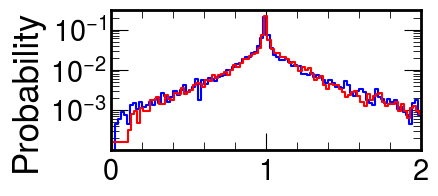

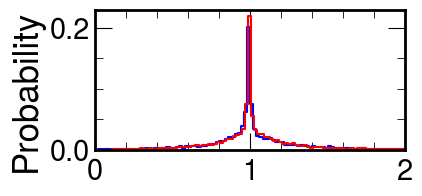

In [7]:
import seaborn as sns
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(2, 1, 1)
sns.histplot(sd_hgb.calibrated_E/sd_hgb.true_showers_E, stat="probability",binwidth=0.02, color="blue",  element="step",fill=False)
sns.histplot(sd_pandora.pandora_calibrated_pfo/sd_pandora.true_showers_E, stat="probability",binwidth=0.02, color="red",  element="step",fill=False)
ax.set_yscale('log')
plt.xlim([0,2])

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(2, 1, 1)
sns.histplot(sd_hgb.calibrated_E/sd_hgb.true_showers_E, stat="probability",binwidth=0.02, color="blue",  element="step",fill=False)
sns.histplot(sd_pandora.pandora_calibrated_pfo/sd_pandora.true_showers_E, stat="probability",binwidth=0.02, color="red",  element="step",fill=False)

plt.xlim([0,2])

(0.0, 2.0)

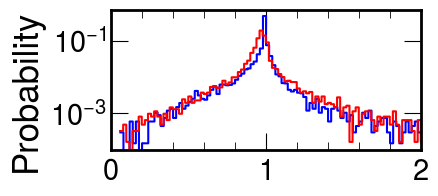

In [8]:
import seaborn as sns
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(2, 1, 1)
sns.histplot(sd_hgb.pred_showers_E/sd_hgb.reco_showers_E, stat="probability",binwidth=0.02, color="blue",  element="step",fill=False)
sns.histplot(sd_pandora.pred_showers_E/sd_pandora.reco_showers_E, stat="probability",binwidth=0.02, color="red",  element="step",fill=False)
ax.set_yscale('log')
plt.xlim([0,2])

(0.0, 2.0)

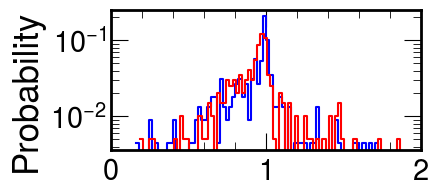

In [9]:
import seaborn as sns
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(2, 1, 1)
sns.histplot(sd_hgb[sd_hgb.pid==130].pred_showers_E/sd_hgb[sd_hgb.pid==130].reco_showers_E, stat="probability",binwidth=0.02, color="blue",  element="step",fill=False)
sns.histplot(sd_pandora[sd_pandora.pid==130].pred_showers_E/sd_pandora[sd_pandora.pid==130].reco_showers_E, stat="probability",binwidth=0.02, color="red",  element="step",fill=False)
ax.set_yscale('log')
plt.xlim([0,2])

(0.0, 2.0)

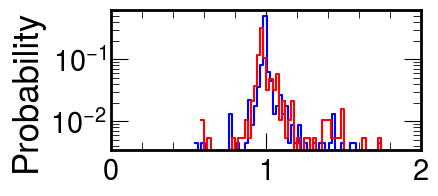

In [10]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(2, 1, 1)
sns.histplot(sd_hgb[sd_hgb.pid==11].pred_showers_E/sd_hgb[sd_hgb.pid==11].reco_showers_E, stat="probability",binwidth=0.02, color="blue",  element="step",fill=False)
sns.histplot(sd_pandora[sd_pandora.pid==11].pred_showers_E/sd_pandora[sd_pandora.pid==11].reco_showers_E, stat="probability",binwidth=0.02, color="red",  element="step",fill=False)
ax.set_yscale('log')
plt.xlim([0,2])

(0.0, 2.0)

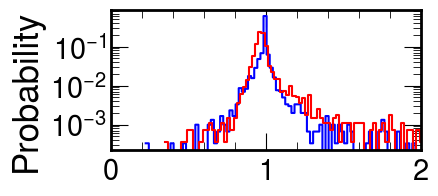

In [11]:
import seaborn as sns
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(2, 1, 1)
sns.histplot(sd_hgb[sd_hgb.pid==22].pred_showers_E/sd_hgb[sd_hgb.pid==22].reco_showers_E, stat="probability",binwidth=0.02, color="blue",  element="step",fill=False)
sns.histplot(sd_pandora[sd_pandora.pid==22].pred_showers_E/sd_pandora[sd_pandora.pid==22].reco_showers_E, stat="probability",binwidth=0.02, color="red",  element="step",fill=False)
ax.set_yscale('log')
plt.xlim([0,2])

(0.0, 2.0)

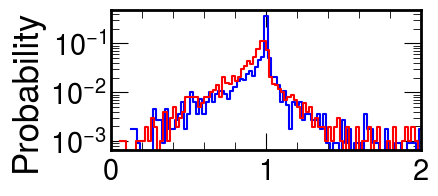

In [12]:
import seaborn as sns
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(2, 1, 1)
sns.histplot(sd_hgb[sd_hgb.pid==-211].pred_showers_E/sd_hgb[sd_hgb.pid==-211].reco_showers_E, stat="probability",binwidth=0.02, color="blue",  element="step",fill=False)
sns.histplot(sd_pandora[sd_pandora.pid==-211].pred_showers_E/sd_pandora[sd_pandora.pid==-211].reco_showers_E, stat="probability",binwidth=0.02, color="red",  element="step",fill=False)
ax.set_yscale('log')
plt.xlim([0,2])

<Axes: xlabel='pred_showers_E', ylabel='Count'>

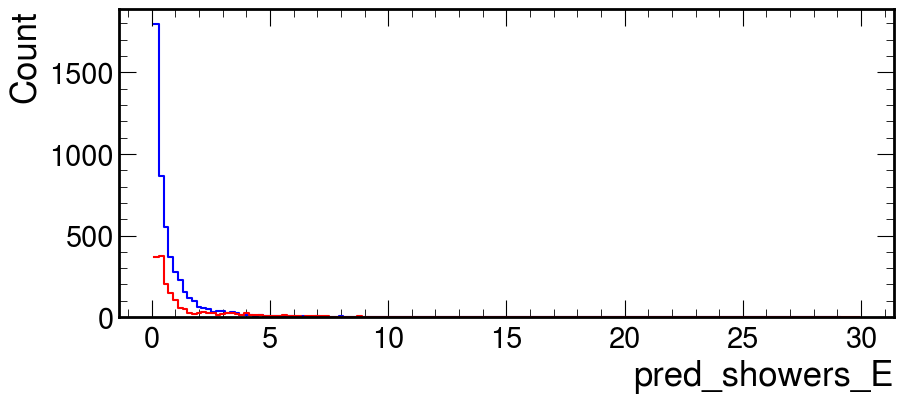

In [51]:
import seaborn as sns
plt.figure(figsize = (10,4))
sns.histplot(sd_hgb[np.isnan(sd_hgb.true_showers_E)*(sd_hgb.pred_showers_E.values>0.10)].pred_showers_E,  binwidth=0.2, color="blue",  element="step",fill=False)
sns.histplot(sd_pandora[np.isnan(sd_pandora.true_showers_E)*(sd_pandora.pred_showers_E.values>0.10)].pred_showers_E, binwidth=0.2, color="red", element="step",fill=False)
# plt.yscale('log')

<Axes: xlabel='pred_showers_E', ylabel='Count'>

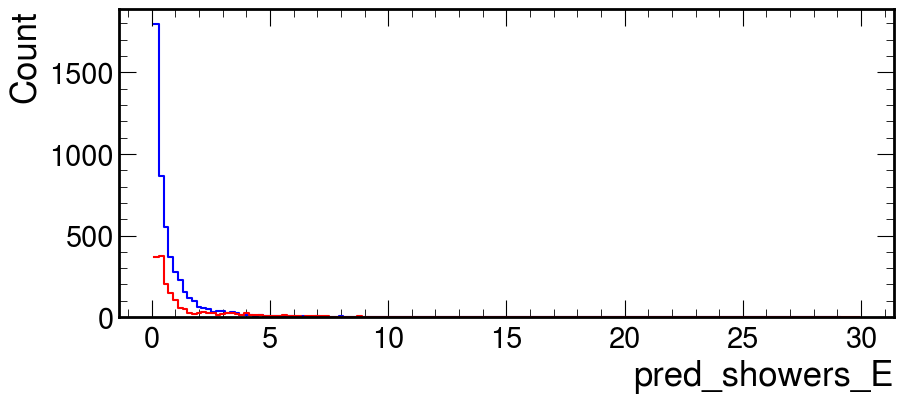

In [52]:
import seaborn as sns
plt.figure(figsize = (10,4))
sns.histplot(sd_hgb[np.isnan(sd_hgb.true_showers_E)*(sd_hgb.pred_showers_E.values>0.10)].pred_showers_E,  binwidth=0.2, color="blue",  element="step",fill=False)
sns.histplot(sd_pandora[np.isnan(sd_pandora.true_showers_E)*(sd_pandora.pred_showers_E.values>0.10)].pred_showers_E, binwidth=0.2, color="red", element="step",fill=False)
# plt.yscale('log')

In [13]:
np.sum(sd_hgb[np.isnan(sd_hgb.true_showers_E)*(sd_hgb.pred_showers_E.values>0.10)].pred_showers_E), np.sum(sd_pandora[np.isnan(sd_pandora.true_showers_E)*(sd_pandora.pred_showers_E.values>0.10)].pred_showers_E)

(3885.8972, 1350.7943)

<Axes: xlabel='pred_showers_E', ylabel='Count'>

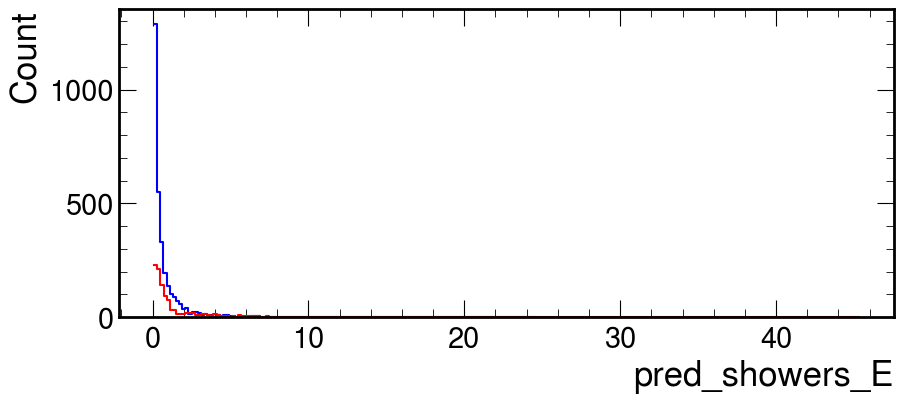

In [52]:
import seaborn as sns
plt.figure(figsize = (10,4))
sns.histplot(sd_hgb[np.isnan(sd_hgb.true_showers_E)*(sd_hgb.pred_showers_E.values>0.10)].pred_showers_E,  binwidth=0.2, color="blue",  element="step",fill=False)
sns.histplot(sd_pandora[np.isnan(sd_pandora.true_showers_E)*(sd_pandora.pred_showers_E.values>0.10)].pred_showers_E, binwidth=0.2, color="red", element="step",fill=False)
# plt.yscale('log')

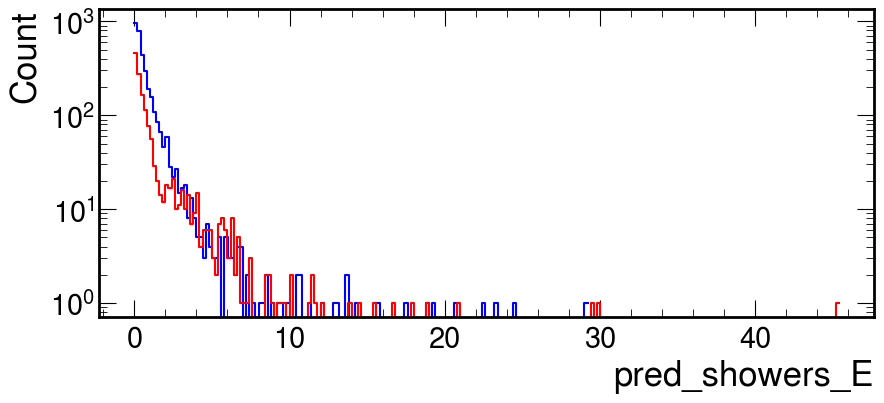

In [20]:
import seaborn as sns
plt.figure(figsize = (10,4))
sns.histplot(sd_hgb[np.isnan(sd_hgb.true_showers_E)].pred_showers_E,  binwidth=0.2, color="blue",  element="step",fill=False)
sns.histplot(sd_pandora[np.isnan(sd_pandora.true_showers_E)].pred_showers_E, binwidth=0.2, color="red", element="step",fill=False)
plt.yscale('log')

In [2]:
# plt.plot(sd_hgb.reco_showers_E, np.exp(sd_hgb.reco_showers_E/15).values,'x')


In [60]:

def get_mask_id(id, pids_pandora):
    mask_id = np.full((len(pids_pandora)), False, dtype=bool)
    for i in id:
        mask_i = np.abs(pids_pandora) == i
        mask_id = mask_id + mask_i
    mask_id = mask_id.astype(bool)
    return mask_id
matched = matched_hgb
pids = np.abs(matched["pid"].values)
mask_id = get_mask_id([2212], pids)
matched = matched[mask_id]

matched_pandora = matched_hgbq1
pids = np.abs(matched_pandora["pid"].values)
mask_id = get_mask_id([2212], pids)
matched_pandora = matched_pandora[mask_id]

In [61]:
distribution_ml = matched.pred_showers_E.values/matched.reco_showers_E.values
mask_e_  = (matched.true_showers_E.values<5 )*(matched.true_showers_E.values>0 )
distribution_pandora = matched_pandora.pred_showers_E.values/matched_pandora.reco_showers_E.values
mask_e_p  = (matched_pandora.true_showers_E.values<5 )*(matched_pandora.true_showers_E.values>0 )

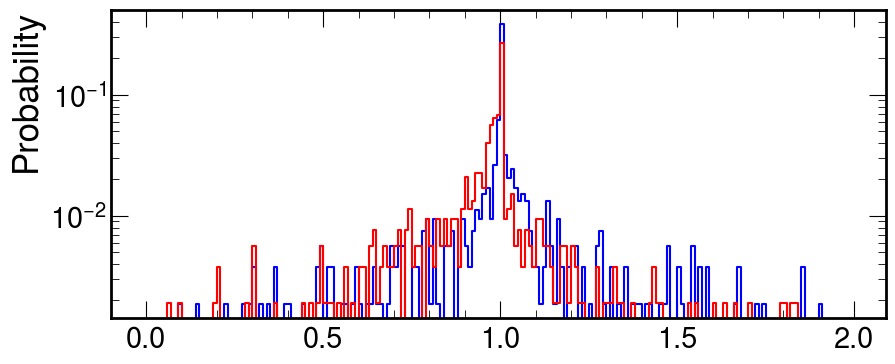

In [67]:
import seaborn as sns
binning = 1e-2
bins_per_binned_E = np.arange(0, 2, binning)
plt.figure(figsize = (10,4))
sns.histplot(distribution_ml[mask_e_], bins = bins_per_binned_E, color="blue", stat="probability", element="step",fill=False)
sns.histplot(distribution_pandora[mask_e_p],  bins = bins_per_binned_E,color="red",stat="probability", element="step",fill=False)
plt.yscale('log')

In [63]:
binning = 1e-2
from scipy import asarray as ar, exp
from scipy.optimize import curve_fit
bins_per_binned_E = np.arange(0, 2, binning)
e_over_reco = distribution_ml[mask_e_]
hist, bin_edges = np.histogram(e_over_reco, bins=bins_per_binned_E, density=True)
# Calculating the Gaussian PDF values given Gaussian parameters and random variable X
def gaus(X, C, X_mean, sigma):
    return C * exp(-((X - X_mean) ** 2) / (2 * sigma**2))
n = len(hist)
x_hist = np.zeros((n), dtype=float)
for ii in range(n):
    x_hist[ii] = (bin_edges[ii + 1] + bin_edges[ii]) / 2
y_hist = hist

mean = sum(x_hist * y_hist) / sum(y_hist)
sigma = sum(y_hist * (x_hist - mean) ** 2) / sum(y_hist)


param_optimised, param_covariance_matrix = curve_fit(
    gaus, x_hist, y_hist, p0=[max(y_hist), mean, sigma], maxfev=10000
)

param_optimised[1], param_optimised[2] / param_optimised[1]

/tmp/mgarciam/ipykernel_325257/3519669631.py:9: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
  return C * exp(-((X - X_mean) ** 2) / (2 * sigma**2))


(1.0042348868768056, 0.004792385677439974)

In [64]:
binning = 1e-2
from scipy import asarray as ar, exp
from scipy.optimize import curve_fit
bins_per_binned_E = np.arange(0, 2, binning)
e_over_reco = distribution_pandora[mask_e_p]
hist, bin_edges = np.histogram(e_over_reco, bins=bins_per_binned_E, density=True)
# Calculating the Gaussian PDF values given Gaussian parameters and random variable X
def gaus(X, C, X_mean, sigma):
    return C * exp(-((X - X_mean) ** 2) / (2 * sigma**2))
n = len(hist)
x_hist = np.zeros((n), dtype=float)
for ii in range(n):
    x_hist[ii] = (bin_edges[ii + 1] + bin_edges[ii]) / 2
y_hist = hist

mean = sum(x_hist * y_hist) / sum(y_hist)
sigma = sum(y_hist * (x_hist - mean) ** 2) / sum(y_hist)


param_optimised, param_covariance_matrix = curve_fit(
    gaus, x_hist, y_hist, p0=[max(y_hist), mean, sigma], maxfev=10000
)
param_optimised[1], param_optimised[2] / param_optimised[1]

/tmp/mgarciam/ipykernel_325257/3768993754.py:9: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
  return C * exp(-((X - X_mean) ** 2) / (2 * sigma**2))


(1.0029600886987877, 0.004656101483621895)

In [9]:
matched = matched_pandora
# bins = np.arange(0, 51, 6)
from src.utils.inference.per_particle_metrics import  get_sigma_gaussian
bins = [0, 5, 15, 35, 50]
mean = []
variance_om = []
mean_baseline = []
variance_om_baseline = []
mean_true_rec = []
variance_om_true_rec = []
mean_errors = []
variance_om_errors = []
energy_resolutions = []
energy_resolutions_reco = []
distributions = []  # distributions of E/Etrue for plotting later
mean_pxyz = []
variance_pxyz = []
masses = []
is_track_in_cluster = []
pxyz_true, pxyz_pred = [], []
sigma_phi, sigma_theta = [], [] # for the angular resolution vs. energy
distr_phi, distr_theta = [], []

binning = 1e-2
bins_per_binned_E = np.arange(0, 2, binning)
for i in range(len(bins) - 1):
    bin_i = bins[i]
    bin_i1 = bins[i + 1]
    mask_above = matched["true_showers_E"] <= bin_i1
    mask_below = matched["true_showers_E"] > bin_i
    mask_check = matched["pred_showers_E"] > 0
    mask = mask_below * mask_above * mask_check
    print("sum mas", np.sum(mask))
    true_e = matched.true_showers_E[mask]
    true_rec = matched.reco_showers_E[mask]

    pred_e_nocor = matched.pred_showers_E[mask]
    true_pxyz = np.array(matched.true_pos[mask].tolist())
    bins_angle = np.linspace(-0.1, +0.1, 400)
    if np.sum(mask) > 0:  # if the bin is not empty
        e_over_reco = true_rec / true_e
        e_over_reco_ML = pred_e_nocor / true_rec
        
        (
            mean_reco_ML,
            var_reco_ML,
            err_mean_reco_ML,
            err_mean_var_reco_ML,
        ) = get_sigma_gaussian(e_over_reco_ML, bins_per_binned_E)
        print("mean_reco_ML", mean_reco_ML)
       
      
        mean_true_rec.append(mean_reco_ML)
        variance_om_true_rec.append(np.abs(var_reco_ML))
     

sum mas 7739
mean_reco_ML 0.968075301987698
sum mas 837
mean_reco_ML 0.9754916337248599
sum mas 118
mean_reco_ML 0.9790731083128748
sum mas 0


In [10]:
variance_om_true_rec

[0.024486182072803606, 0.01932306692028565, 0.032195650774175896]

In [12]:
variance_om_true_rec

[]

In [11]:
bins = [0, 5, 15, 35, 50]
mean = []
variance_om = []
mean_baseline = []
variance_om_baseline = []
mean_true_rec = []
variance_om_true_rec = []
mean_errors = []
variance_om_errors = []
energy_resolutions = []
energy_resolutions_reco = []
distributions = []  # distributions of E/Etrue for plotting later
mean_pxyz = []
variance_pxyz = []
masses = []
is_track_in_cluster = []
pxyz_true, pxyz_pred = [], []
sigma_phi, sigma_theta = [], [] # for the angular resolution vs. energy
distr_phi, distr_theta = [], []
#distribution_slice_5_6_GeV = []
# tic = time.time()
# vector = range(len(bins) - 1)
# output_results = parallel_process(vector, bins, matched, pandora, bins_per_binned_E)
# mean_true_rec = [r[0] for ind, r in enumerate(output_results)]
# variance_om_true_rec = [r[1] for ind, r in enumerate(output_results)]
# energy_resolutions_reco = [r[2] for ind, r in enumerate(output_results)]
# toc = time.time()
# print("time with paralel version", toc - tic)
print("START PANDORA")
binning = 1e-2
bins_per_binned_E = np.arange(0, 2, binning)
for i in range(len(bins) - 1):
    bin_i = bins[i]
    bin_i1 = bins[i + 1]
    mask_above = matched["true_showers_E"] <= bin_i1
    mask_below = matched["true_showers_E"] > bin_i
    mask_check = matched["pred_showers_E"] > 0
    mask = mask_below * mask_above * mask_check
    print("sum mas", np.sum(mask))

START PANDORA
sum mas 7739
sum mas 837
sum mas 118
sum mas 0


In [3]:
# reduced_p = sd_pandora[sd_pandora.pid==130]
# reduced_p[np.isnan(reduced_p.pred_showers_E)]

In [13]:
def calculate_eff(sd, log_scale=False):
    if log_scale:
        bins = np.exp(np.arange(np.log(0.1), np.log(80), 0.3))
    else:
        bins = np.arange(0, 51, 5)
    eff = []
    energy_eff = []
    errors = []
    for i in range(len(bins) - 1):
        bin_i = bins[i]
        bin_i1 = bins[i + 1]
        mask_above = sd.reco_showers_E.values <= bin_i1
        mask_below = sd.reco_showers_E.values > bin_i
        mask = mask_below * mask_above
        number_of_non_reconstructed_showers = np.sum(
            np.isnan(sd.pred_showers_E.values)[mask]
        )
        total_showers = len(sd.pred_showers_E.values[mask])
        if total_showers > 0:
            eff.append(
                (total_showers - number_of_non_reconstructed_showers) / total_showers
            )
            energy_eff.append((bin_i1 + bin_i) / 2)
            n_total = total_showers
            n_r = total_showers - number_of_non_reconstructed_showers
            error = (n_r/(n_total**2)*np.sqrt(n_total))**2+(1/n_total*np.sqrt(n_r))**2
            print(total_showers, n_r, error)
            error = np.sqrt(error)
            errors.append(error)
    return eff, energy_eff, errors

def create_eff_dic(photons_dic, matched_, id, var_i):
    pids = np.abs(matched_["pid"].values)
    mask_id = pids == id
    df_id = matched_[mask_id]

    eff, energy_eff, errors = calculate_eff(df_id, False)
    photons_dic["eff_" + str(var_i)] = eff
    photons_dic["energy_eff_" + str(var_i)] = energy_eff
    photons_dic["errors" + str(var_i)] = errors
    return photons_dic

def create_eff_dic_pandora(matched_pandora, id):
    pids_pandora = np.abs(matched_pandora["pid"].values)
    mask_id = pids_pandora == id
    df_id_pandora = matched_pandora[mask_id]
    eff_p, energy_eff_p, errors = calculate_eff(df_id_pandora, False)
    photons_dic = {}
    photons_dic["eff_p"] = eff_p
    photons_dic["energy_eff_p"] = energy_eff_p
    photons_dic["errors_p"] = errors
    return photons_dic

In [14]:
# from src.utils.inference.per_particle_metrics import create_eff_dic_pandora, create_eff_dic
photons_dic = create_eff_dic_pandora(sd_pandora, 22)
electrons_dic = create_eff_dic_pandora(sd_pandora, 11)
pions_dic = create_eff_dic_pandora(sd_pandora, 211)
kaons_dic = create_eff_dic_pandora(sd_pandora, 130)

var_i = "0"
photons_dic = create_eff_dic(photons_dic, sd_hgb, 22, var_i=var_i)
electrons_dic = create_eff_dic(electrons_dic, sd_hgb, 11, var_i=var_i)
pions_dic = create_eff_dic(pions_dic, sd_hgb, 211, var_i=var_i)
kaons_dic = create_eff_dic(kaons_dic, sd_hgb, 130, var_i=var_i)


8682 7724 0.00019363578826451215
657 607 0.002705450898850806
241 233 0.007890111399011296
83 80 0.022805695127731136
34 33 0.05625381640545492
11 9 0.13523666416228397
8 8 0.25000000000000006
1377 1113 0.0010614332564319027
81 72 0.020728547477518663
17 17 0.11764705882352941
3 3 0.6666666666666666
2 2 1.0000000000000002
3 3 0.6666666666666666
5511 4914 0.000306069449717713
1159 1068 0.0015277108457167916
464 431 0.0038614139731282544
244 224 0.007216463051973513
125 119 0.014866431999999999
62 61 0.031481823369474
27 27 0.07407407407407408
13 13 0.15384615384615385
4 4 0.5
246 182 0.005232507213035645
126 92 0.01002611509036301
114 93 0.012993876658405014
75 62 0.02013392592592593
70 68 0.02735860058309038
63 62 0.030994173095458058
29 28 0.06543933740620772
24 24 0.08333333333333331
15 15 0.13333333333333336
8 8 0.25000000000000006
8682 8353 0.0002174329082739104
657 635 0.002892944688595054
241 235 0.007991415051279437
83 81 0.02323242745987579
34 34 0.05882352941176471
11 9 0.1352

(0.55, 1.05)

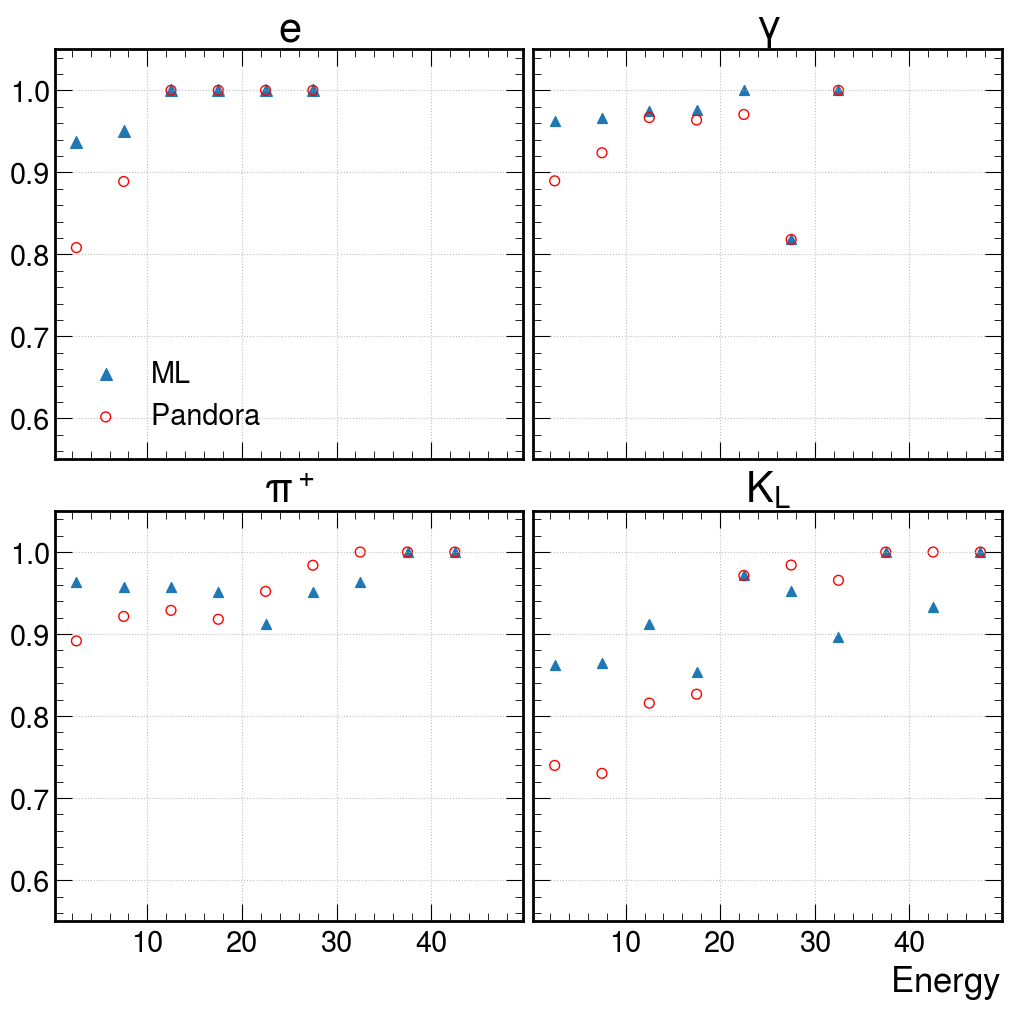

In [15]:
colors_list = ["#FF0000", "#FF0000", "#0000FF"]
markers = ["^", "*", "x", "d", ".", "s"]
i =0
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, layout="constrained")
axs[0, 0].scatter(
            electrons_dic["energy_eff_" + str(i)],
            electrons_dic["eff_" + str(i)],
            label="ML", 
            marker=markers[i],
            s=70,
        )
# axs[0, 0].errorbar(electrons_dic["energy_eff_" + str(i)], electrons_dic["eff_" + str(i)] ,yerr= electrons_dic["errors" + str(i)], linestyle='none')

axs[0, 0].scatter(
    electrons_dic["energy_eff_p"],
    electrons_dic["eff_p"],
    facecolors='none',
    edgecolors="r",
    label="Pandora " ,
    marker="o",
    s=50,
)
# axs[0, 0].errorbar(electrons_dic["energy_eff_p"], electrons_dic["eff_p"] ,yerr= electrons_dic["errors_p"], linestyle='none')

axs[0, 0].set_title("$e$")
axs[0,0].set_ylim([0.55,1.05])
axs[0,0].grid()
axs[0,0].legend()
axs[0, 1].scatter(
            photons_dic["energy_eff_" + str(i)],
            photons_dic["eff_" + str(i)],
            label="ML", 
            marker=markers[i],
            s=50,
        )
# axs[0, 1].errorbar(photons_dic["energy_eff_" + str(i)], photons_dic["eff_" + str(i)] ,yerr= photons_dic["errors" + str(i)], linestyle='none')

axs[0, 1].scatter(
    photons_dic["energy_eff_p"],
    photons_dic["eff_p"],
    facecolors='none',
    edgecolors="r",
    label="Pandora " ,
    marker="o",
    s=50,
)
# axs[0, 1].errorbar(photons_dic["energy_eff_p"], photons_dic["eff_p"] ,yerr= photons_dic["errors_p"], linestyle='none')

axs[0, 1].set_title("$\\gamma$")
axs[0, 1].set_ylim([0.55,1.05])
axs[0, 1].grid()
axs[1, 0].scatter(
            pions_dic["energy_eff_" + str(i)],
            pions_dic["eff_" + str(i)],
            label="ML", 
            marker=markers[i],
            s=50,
        )
axs[1, 0].scatter(
    pions_dic["energy_eff_p"],
    pions_dic["eff_p"],
    facecolors='none',
    edgecolors="r",
    label="Pandora " ,
    marker="o",
    s=50,
)
axs[1, 0].set_title("$\\pi^+$")
axs[1, 0].set_ylim([0.55,1.05])
axs[1, 0].grid()
axs[1, 1].scatter(
            kaons_dic["energy_eff_" + str(i)],
            kaons_dic["eff_" + str(i)],
            label="ML", 
            marker=markers[i],
            s=50,
        )
# axs[1, 1].errorbar(kaons_dic["energy_eff_" + str(i)], kaons_dic["eff_" + str(i)] ,yerr= kaons_dic["errors" + str(i)], linestyle='none')

axs[1, 1].scatter(
    kaons_dic["energy_eff_p"],
    kaons_dic["eff_p"],
    facecolors='none',
    edgecolors="r",
    label="Pandora " ,
    marker="o",
    s=50,
)
# axs[1, 1].errorbar(kaons_dic["energy_eff_p"], kaons_dic["eff_p"] ,yerr= kaons_dic["errors_p"], linestyle='none')

axs[1, 1].set_title("$K_L$")
axs[1, 1].set_xlabel("$Energy$")
axs[1, 1].grid()
axs[1, 1].set_ylim([0.55,1.05])